In [1]:
DATA_DIR = './data/images/'

import os

import cv2
from PIL import Image

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from typing import List

import seaborn as sns
sns.set()

from collections import defaultdict

In [2]:
import torch
import sys
import src.utils.transform as trf
from src.archs import resnet18_rank_DA

In [3]:
def plot_array(images):
    n = len(images)
    fig, axarr = plt.subplots(1, n, figsize=(n*5,5))
    for i in range(n):
        axarr[i].imshow(images[i], zorder=1)

In [4]:
ADS_IMAGES_DIR = os.path.join(DATA_DIR, 'ads_images')


In [5]:
img1 = plt.imread(os.path.join(ADS_IMAGES_DIR, 'leboncoin_images1.jpg'))
leboncoin_logo = plt.imread(os.path.join(DATA_DIR, 'leboncoin_logo.jpg'))
seloger_logo = plt.imread(os.path.join(DATA_DIR, 'seloger_logo.jpg'))

img2 = cv2.resize(img1, (300, 300))

In [6]:
images = []
for file in os.listdir(ADS_IMAGES_DIR):
    images.append(plt.imread(os.path.join(ADS_IMAGES_DIR, file)))

## Transformations

In [7]:
def crop(img, top_crop=0, bottom_crop=0, left_crop=0, right_crop=0):
    height, width, _ = img.shape
    top, bottom = int(top_crop*height), int((1-bottom_crop)*height)+1
    left, right = int(left_crop*width), int((1-right_crop)*width)+1
    return img[top: bottom,left:right ]


def generate_resized_images(img: np.ndarray, resize_rates: List, direction: str):
    """
    Given an image return an array of resized images
    resize_rates is the list of the resizeing rates we want to apply.
    If direction is equal to horizontal or vertical it has to be a list of float else if it equal
    to both it has to be a list of couple of float representing height rate and width rate
    """
    resized_images = []
    (height, width) = img.shape[:2]
    if direction == 'horizontal':
        for resize_rate in resize_rates:
            resized_images.append(cv2.resize(img, (int(width*resize_rate), height)))
            
    if direction == 'vertical':
        for resize_rate in resize_rates:
            resized_images.append(cv2.resize(img, (width, int(height*resize_rate))))
            
    if direction == 'both':
        for height_resize_rate, width_resize_rate in resize_rates:
            resized_images.append(cv2.resize(img, (int(width*width_resize_rate), int(height*height_resize_rate))))
            
    return resized_images

def generate_blur_images(img: np.ndarray, kernel_sizes: List):
    blur_images = []
    for kernel_size in kernel_sizes:
        blur_images.append(cv2.blur(img, ksize=(kernel_size, kernel_size)))
    return blur_images

def generate_croped_images(img: np.ndarray, crop_rates: List, direction: str):
    """
    Given an image return an array of cropped images
    crop_rates is the list of the cropping rates we want to apply.
    If direction is equal to horizontal or vertical it has to be a list of float else if it equal
    to both it has to be a list of couple of float representing height rate and width rate
    """
    cropped_images = []
    if direction == 'horizontal':
        for crop_rate in crop_rates:
            cropped_images.append(crop(img, left_crop=crop_rate/2, right_crop=crop_rate/2))
            
    if direction == 'vertical':
        for crop_rate in crop_rates:
            cropped_images.append(crop(img, top_crop=crop_rate/2, bottom_crop=crop_rate/2))
            
    if direction == 'both':
        for height_crop_rate, width_crop_rate in crop_rates:
            cropped_images.append(
                crop(img, left_crop=width_crop_rate/2, right_crop=width_crop_rate/2, 
                     top_crop=height_crop_rate/2, bottom_crop=height_crop_rate/2)
            )
            
    return cropped_images

def add_logo(img: np.ndarray, rates: List, logo: np.ndarray):
    logo = Image.fromarray(np.uint8(logo))
    img = Image.fromarray(np.uint8(img))
    width, height = logo.size
    images_with_logo = []
    for rate in rates:
        image_with_logo = img.copy()
        logo_width = int(img.size[0]*rate)
        logo_height = int(height / (width / logo_width))
        image_with_logo.paste(logo.resize((logo_width, logo_height)), (0,0))
        images_with_logo.append(np.array(image_with_logo))
    
    return images_with_logo


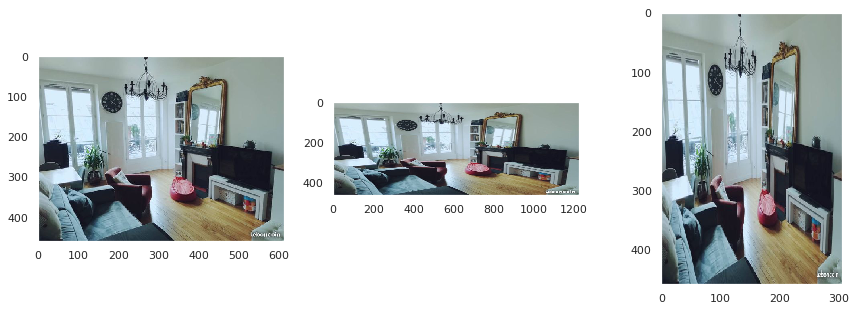

In [8]:
plot_array([img1] + generate_resized_images(img1, [2,0.5], 'horizontal'))
#plt.savefig('resize_horizontal.jpg')

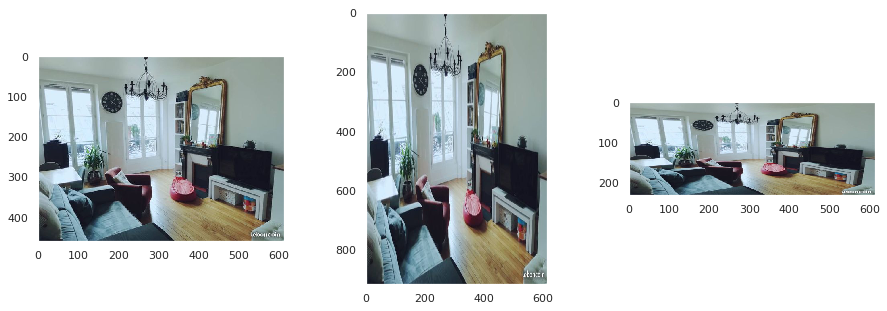

In [9]:
plot_array([img1] + generate_resized_images(img1, [2,0.5], 'vertical'))
#plt.savefig('resize_vertical.jpg')

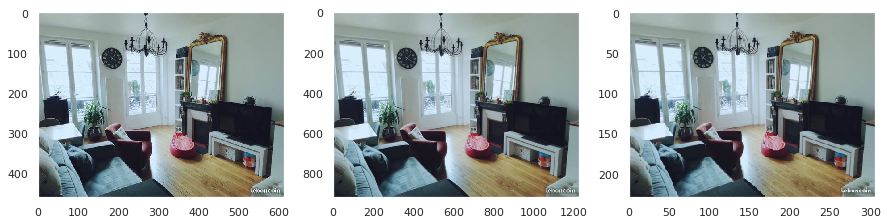

In [10]:
plot_array([img1] + generate_resized_images(img1, [(2,2),(0.5,0.5)], 'both'))
#plt.savefig('resize_both.jpg')

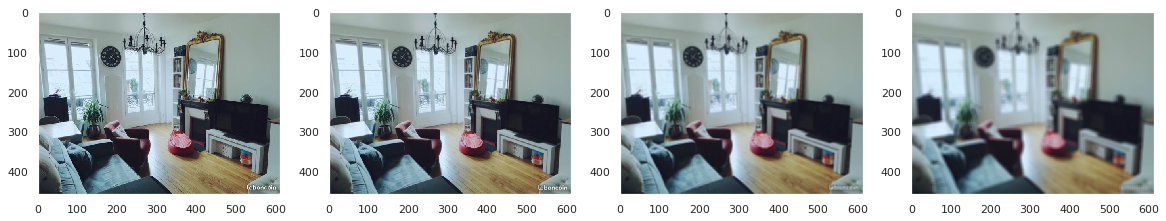

In [11]:
plot_array([img1] + generate_blur_images(img1, [2, 5, 10]))
#plt.savefig('blur.jpg')

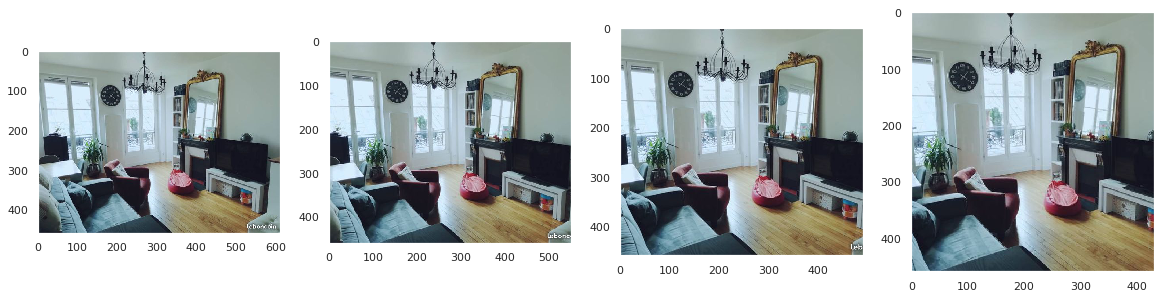

In [12]:
plot_array([img1] + generate_croped_images(img1, [0.1,0.2, 0.3], 'horizontal'))
#plt.savefig('crop_horizontal.jpg')

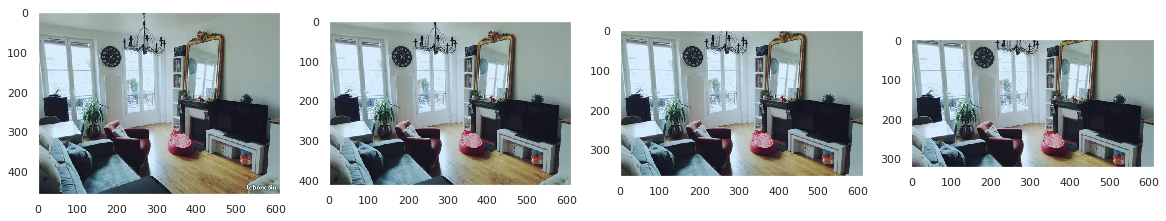

In [13]:
plot_array([img1] + generate_croped_images(img1, [0.1,0.2, 0.3], 'vertical'))
#plt.savefig('crop_vertical.jpg')

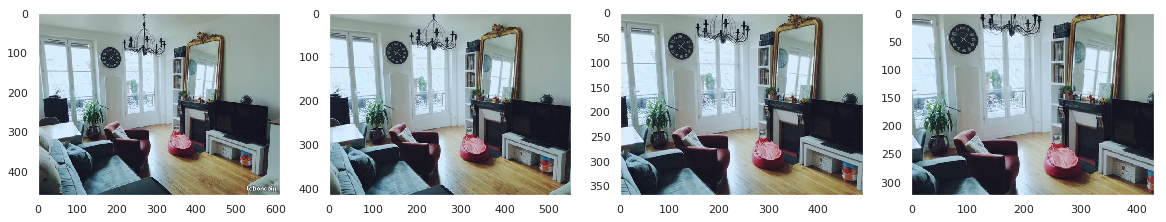

In [14]:
plot_array([img1] + generate_croped_images(img1, [(0.1, 0.1),(0.2, 0.2), (0.3, 0.3)], 'both'))
#plt.savefig('crop_both.jpg')

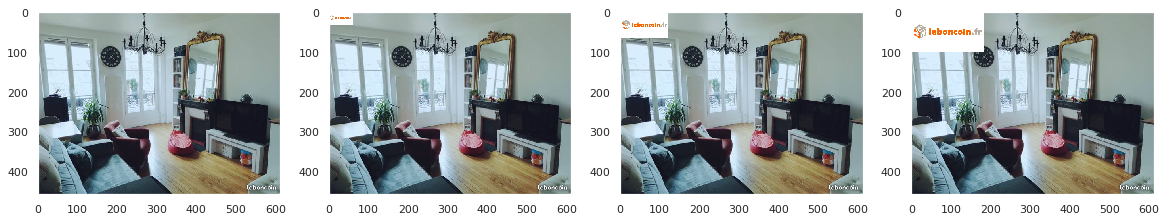

In [15]:
plot_array([img1] + add_logo(img1, [0.1,0.2, 0.3], leboncoin_logo))
#plt.savefig('add_leboncoin.jpg')

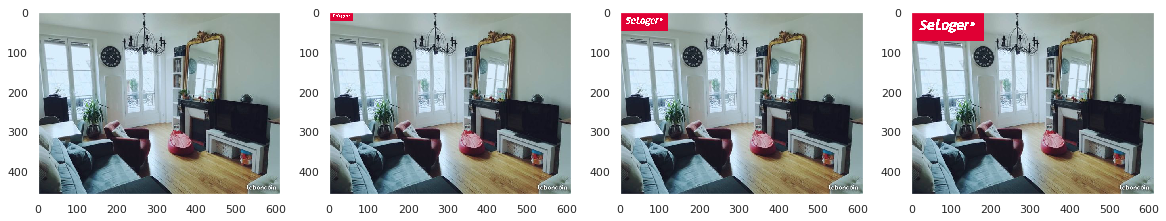

In [16]:
plot_array([img1] + add_logo(img1, [0.1,0.2, 0.3], seloger_logo))
#plt.savefig('add_seloger.jpg')

### Local features

In [17]:
def extract_sift(imgs, nb_features=50):
    features = []
    for img in imgs:
        gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        kp, des = sift.detectAndCompute(img, None)
        features.append((kp[:nb_features], des[:nb_features]))
    return features

def percentage_of_matches(good_matches, nb_features):
    return len(good_matches) / nb_features

def mean_distance(matches):
    return sum(matche[0].distance for matche in matches)/len(matches)


def similarity(u, v):
    if u.ndim == 1:
        return np.dot(u, v)/(np.linalg.norm(u) * np.linalg.norm(v) + 1e-12)
    else:
        return np.sum(np.multiply(u, v), axis=1) / (np.linalg.norm(u, axis=1) * np.linalg.norm(v, axis=1) + 1e-12)

def mean_similarity(matches, des1, des2):
    des1_index = []
    des2_index = []
    for matche in matches:
        des1_index.append(matche[0].queryIdx)
        des2_index.append(matche[0].trainIdx)

    return np.mean(similarity(des1[des1_index], des2[des2_index]))


def extract_matches(kp1, des1, kp2, des2, lowe_ratio=0.7,min_match_count=5, ransac=True):
    
    matches = bf.knnMatch(des1,des2, k=2)

    lowe_matches = []
    for m,n in matches:
        if m.distance < lowe_ratio*n.distance:
            lowe_matches.append([m])
    if ransac and len(lowe_matches)>min_match_count:
        src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in lowe_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in lowe_matches ]).reshape(-1,1,2)

        _ , mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        filtered_matches = []
        for i, is_match in enumerate(matchesMask):
            if is_match == 1:
                filtered_matches.append(lowe_matches[i])
        return filtered_matches
    elif not ransac:
        return lowe_matches

def plot_matches(img1, img2, kp1, kp2, matches):
    #cv2.drawMatchesKnn expects list of lists as matches.
    img3 = None
    img3 = cv2.drawMatchesKnn(img,kp1,img2,kp2,[x for x in matches],img3,flags=2)

    plt.figure(figsize=(20,20))
    plt.imshow(img3)

In [18]:
nb_features = 50
MIN_MATCH_COUNT = 5

sift = cv2.xfeatures2d.SIFT_create(nb_features)
bf = cv2.BFMatcher()

In [19]:
(kp1, des1), (kp2, des2) = extract_sift([img1, img2], nb_features)
matches = extract_matches(kp1, des1, kp2, des2, lowe_ratio=0.99)

In [20]:
def local_similarities(matches, des1, des2, nb_features):
    functions_dict = {
        'percentage_of_matches': (percentage_of_matches, [matches, nb_features]),
        #'mean_distance': (mean_distance, [matches]),
        'mean_similarity': (mean_similarity, [matches, des1, des2]) 
    }
    results = {}
    for function_name, (function, args) in functions_dict.items():
        results[function_name] = function(*args)
    return results

In [21]:
local_similarities(matches, des1, des2, nb_features)

{'percentage_of_matches': 0.42, 'mean_similarity': 0.9543616}

### Global features

In [22]:
import imagehash

In [23]:
pil_img1 = Image.fromarray(np.uint8(img1))
pil_img2 = Image.fromarray(np.uint8(img2))

In [24]:
def hash_similarities(pil_img1, pil_img2):
    def hash_similarity(pil_img1, pil_img2, hash_function):
        hash_size = 64
        return (hash_size - (hash_function(pil_img1) - hash_function(pil_img2)))/hash_size
    
    hash_functions = {
        'dhash': imagehash.dhash,
        'phash': imagehash.phash,
        'ahash': imagehash.average_hash,
        'whash': imagehash.whash
    } 
    
    results = {}
    
    for hash_name, hash_function in hash_functions.items():
        res= hash_similarity(pil_img1, pil_img2, hash_function)
        results[hash_name] = res
    return results



In [25]:
hash_similarities(pil_img1, pil_img2)

{'dhash': 1.0, 'phash': 1.0, 'ahash': 0.96875, 'whash': 1.0}

### Deep learning features

In [26]:
model = resnet18_rank_DA()

def extract_dl_features(model, img):
    img = trf.resize_image(img, 800)
    device='cpu'
    I = trf.to_tensor(img)
    I = trf.normalize(I, dict(rgb_means=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    I = I.unsqueeze(0).to(device)
    with torch.no_grad():
        q_feat = model(I).cpu().numpy()
    return q_feat

def similarity(u, v):
    if u.ndim == 1:
        return np.dot(u, v)/(np.linalg.norm(u) * np.linalg.norm(v) + 1e-12)
    else:
        return np.sum(np.multiply(u, v), axis=1) / (np.linalg.norm(u, axis=1) * np.linalg.norm(v, axis=1) + 1e-12)


### All features and similarities

In [27]:
def compute_features(img):
    pil_img = Image.fromarray(np.uint8(img))
    return {
        'dl': extract_dl_features(model, pil_img),
        'local': extract_sift([img], nb_features)[0]
    }

def compute_similarities(img1, img2, features1, features2):    
    pil_img1 = Image.fromarray(np.uint8(img1))
    pil_img2 = Image.fromarray(np.uint8(img2))
    kp1, des1 = features1['local']
    kp2, des2 = features2['local']
    matches = extract_matches(kp1, des1, kp2, des2, lowe_ratio=0.99)
    
    return {
        **local_similarities(matches, des1, des2, nb_features),
        **hash_similarities(pil_img1, pil_img2),
        'dl': similarity(features1['dl'], features2['dl'])
    } 
    
    
    
    

In [28]:
features1 = compute_features(img1)

features2 = compute_features(img2)

compute_similarities(img1, img2, features1 , features2)

{'percentage_of_matches': 0.42,
 'mean_similarity': 0.9543616,
 'dhash': 1.0,
 'phash': 1.0,
 'ahash': 0.96875,
 'whash': 1.0,
 'dl': 0.9835948963638368}

# Similarity between images that are different


In [29]:
transformation_dict = {
    'blur': (generate_blur_images, [i for i in range(2,10)]),
    'resized_vertical': (generate_resized_images, [2, 1.5, 1.25, 1, 0.75, 0.5, 0.3, 0.2, 0.15, 0.1], 'vertical'),
    'resized_horizontal': (generate_resized_images, [2, 1.5, 1.25, 1, 0.75, 0.5, 0.3, 0.2, 0.15, 0.1], 'horizontal'),
    'resize_both_proportional': (generate_resized_images, [[2, 2], [1.5, 1.5], [1.25, 1.25], [1,1], [0.75, 0.75], [0.5, 0.5], [0.3, 0.3], [0.2, 0.2], [0.15, 0.15], [0.1,0.1]], 'both'),
    'crop_vertical': (generate_croped_images, [0.01, 0.05, 0.1, 0.15, 0.2, 0.25], 'vertical'),
    'crop_horizontal': (generate_croped_images, [0.01, 0.05, 0.1, 0.15, 0.2, 0.25], 'horizontal'),
    'crop_both_proportional': (generate_croped_images, [[0.01, 0.01], [0.05, 0.05], [0.1, 0.1], [0.15, 0.15], [0.2, 0.2], [0.25,0.25]], 'both'),
    'add_leboncoin_logo': (add_logo, [0.01, 0.05, 0.1, 0.15, 0.20], leboncoin_logo),
    'add_seloger_logo': (add_logo, [0.01, 0.05, 0.1, 0.15, 0.20], seloger_logo)

}

xlabels = {
    'blur': 'kernel_size',
    'resized_vertical': 'Resizing factor',
    'resized_horizontal': 'Resizing factor',
    'resize_both_proportional': 'Resizing factor',
    'crop_vertical': 'cropping proportion',
    'crop_horizontal': 'cropping proportion',
    'crop_both_proportional': 'cropping proportion',
    'add_leboncoin_logo': 'width proportion occupied by the logo',
    'add_seloger_logo': 'width proportion occupied by the logo'
}

colors = {
    'percentage_of_matches':"#9b59b6",
    'mean_similarity':"#3498db",
    'dhash': "#95a5a6",
    'phash': "#e74c3c",
    'ahash':"#34495e",
    'whash':"#2ecc71",
    'dl':'#feb308',
    
}

###### Compute max cross similarity

In [30]:
cross_similarities = {key: np.zeros((len(images), len(images))) for key in colors}

for i, img1 in enumerate(images):
    features1 = compute_features(img1)
    for j, img2 in enumerate(images):
        features2 = compute_features(img2)
        sim = compute_similarities(img1, img2, features1, features2)
        for key, value in sim.items():
            cross_similarities[key][i][j] = value


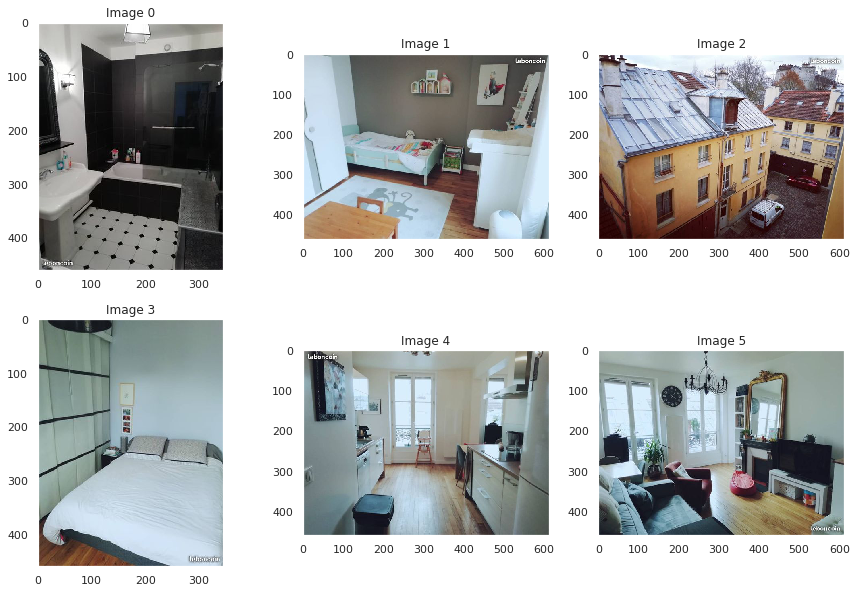

In [31]:
fig, axarr = plt.subplots(2,3, figsize=(15,10))
for i, image in enumerate(images):
    axarr[i//3][i%3].imshow(image, zorder=1)
    axarr[i//3][i%3].set_title(f'Image {i}')
#plt.savefig('all_images.jpg')

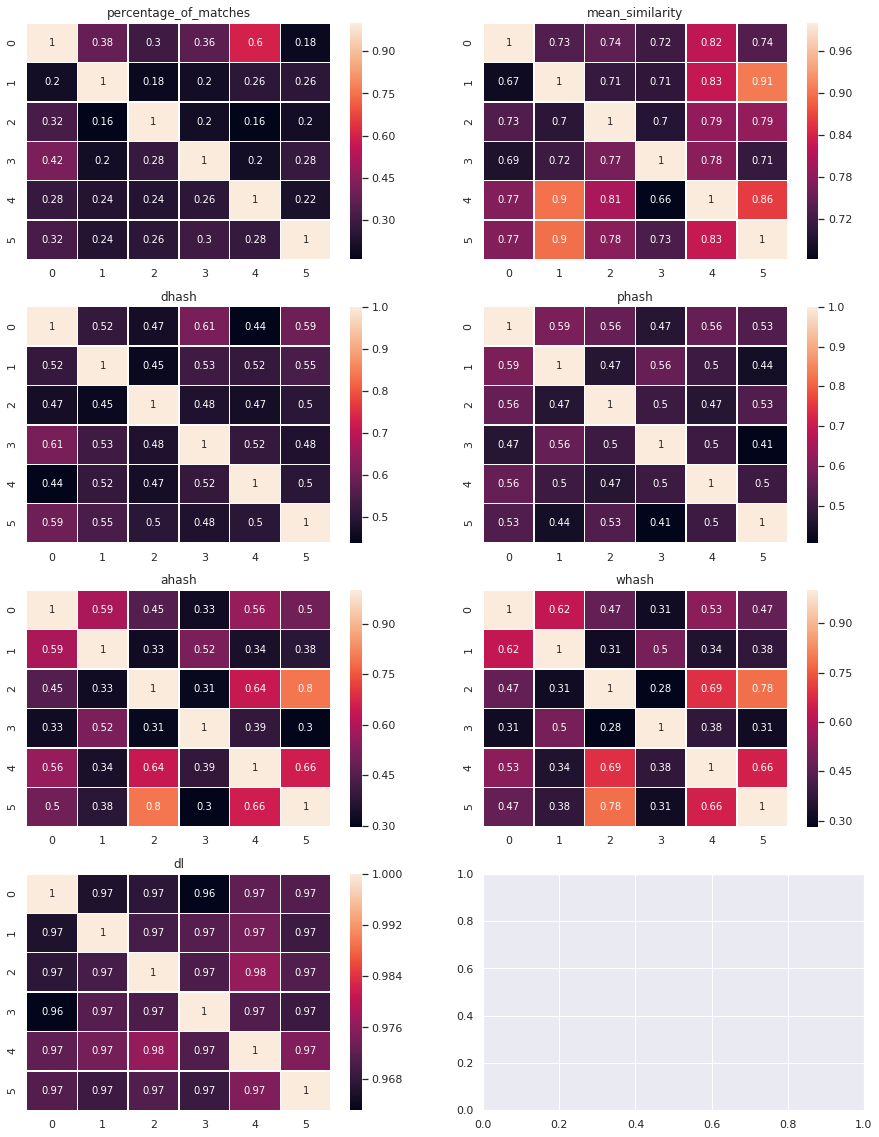

In [32]:
fig, axarr = plt.subplots(4,2, figsize=(15,20))
for i, (sim_name, sim_matrix) in enumerate(cross_similarities.items()):
    sns.heatmap(sim_matrix, linewidth=0.5, ax=axarr[i//2][i%2], annot=True)
    axarr[i//2][i%2].set_title(sim_name)
plt.savefig('cross_similarities.jpg')

In [33]:
max_similarities = {}
for sim_name, sim_matrix in cross_similarities.items():
    max_similarities[sim_name] = np.max(sim_matrix[sim_matrix < 0.99])

# Similarity on tranformation of the same image

In [34]:
def get_transformation_similarities(img1, function, args):
    transformed_images = function(img1, *args)
    similarities = defaultdict(list)
    features1 = compute_features(img1)
    for img2 in transformed_images:
        features2 = compute_features(img2)
        for key, value in compute_similarities(img1, img2, features1, features2).items():
            similarities[key].append(value)
    return similarities
        

In [35]:
transformation_similarities = {}
for transf_name, params in transformation_dict.items():
    function = params[0]
    args = params[1:]
    transformation_similarities[transf_name] = get_transformation_similarities(img1, function, args)

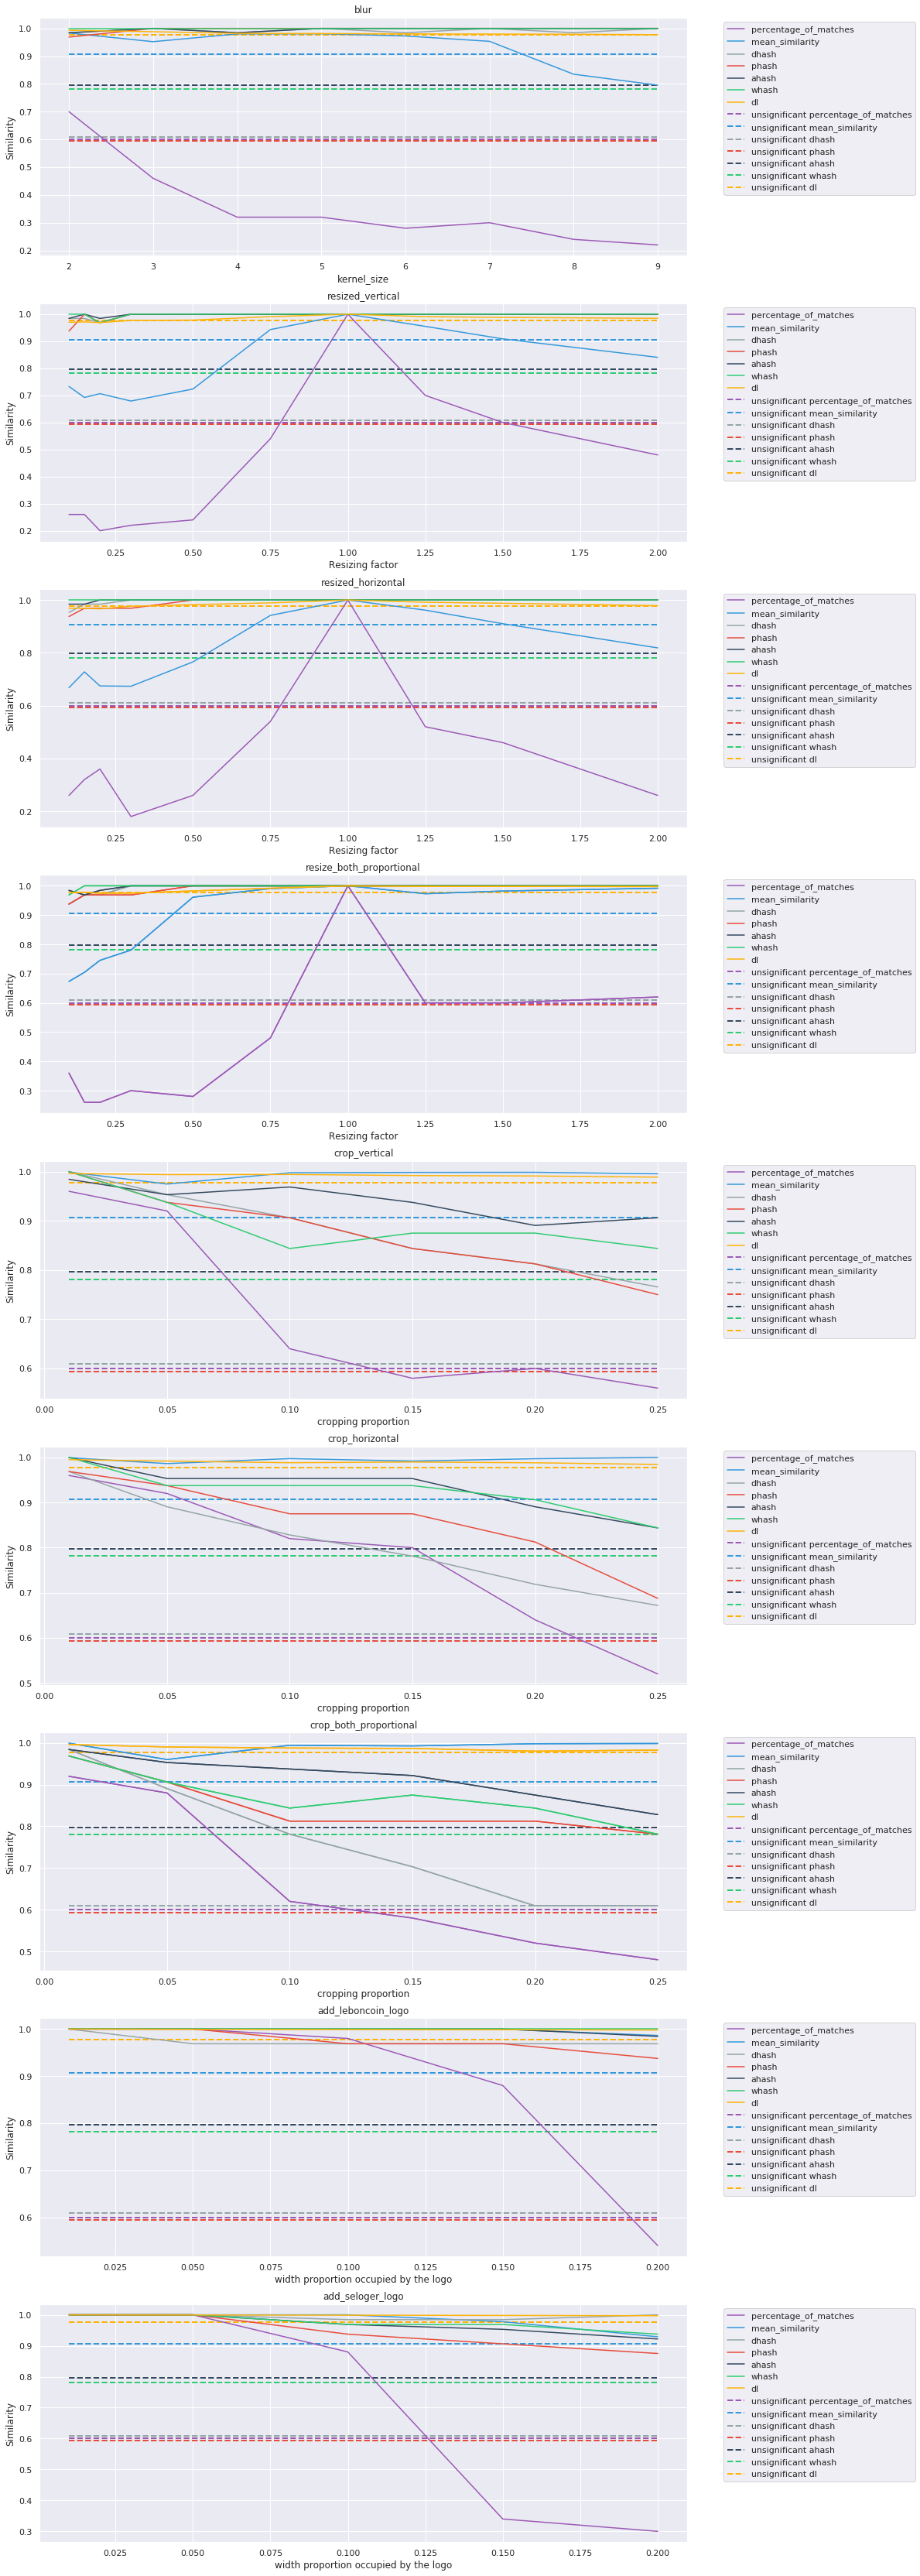

In [36]:
fig, axarr = plt.subplots(len(transformation_similarities), 1, figsize=(15, 60))
for i, (transf_name, similarities) in enumerate(transformation_similarities.items()):
    axes = []
    hlines = []
    index = transformation_dict[transf_name][1]
    max_index = max(index)
    min_index = min(index)
    for sim_name, values in similarities.items():
        ax = axarr[i].plot(index, values, color=colors[sim_name], label=sim_name)
        axes.append(ax[0])
        hl = axarr[i].hlines(
            max_similarities[sim_name], min_index, max_index, linestyles='dashed', color=colors[sim_name],
            label=f'unsignificant {sim_name}', lw=2
        )
        hlines.append(hl)
    axarr[i].legend(handles=axes+hlines, loc='upper left',bbox_to_anchor=(1.05, 1))
    axarr[i].set_title(transf_name)
    axarr[i].set_xlabel(xlabels[transf_name])
    axarr[i].set_ylabel('Similarity')


# Mean similarity for transformations

In [37]:
transformation_mean_similarities = defaultdict(lambda :defaultdict(list))
for image in images:
    for transf_name, params in transformation_dict.items():
        function = params[0]
        args = params[1:]
        for sim_name, sim_value in get_transformation_similarities(image, function, args).items():
            transformation_mean_similarities[transf_name][sim_name].append(sim_value)

In [38]:
mean_similarities = defaultdict(dict)
std_similarities = defaultdict(dict)

for trans_name, trans_dict in transformation_mean_similarities.items():
    for sim_name, values in trans_dict.items():
        mean_similarities[trans_name][sim_name] = np.mean(np.array(values), axis=0)
        std_similarities[trans_name][sim_name] = np.std(np.array(values), axis=0)

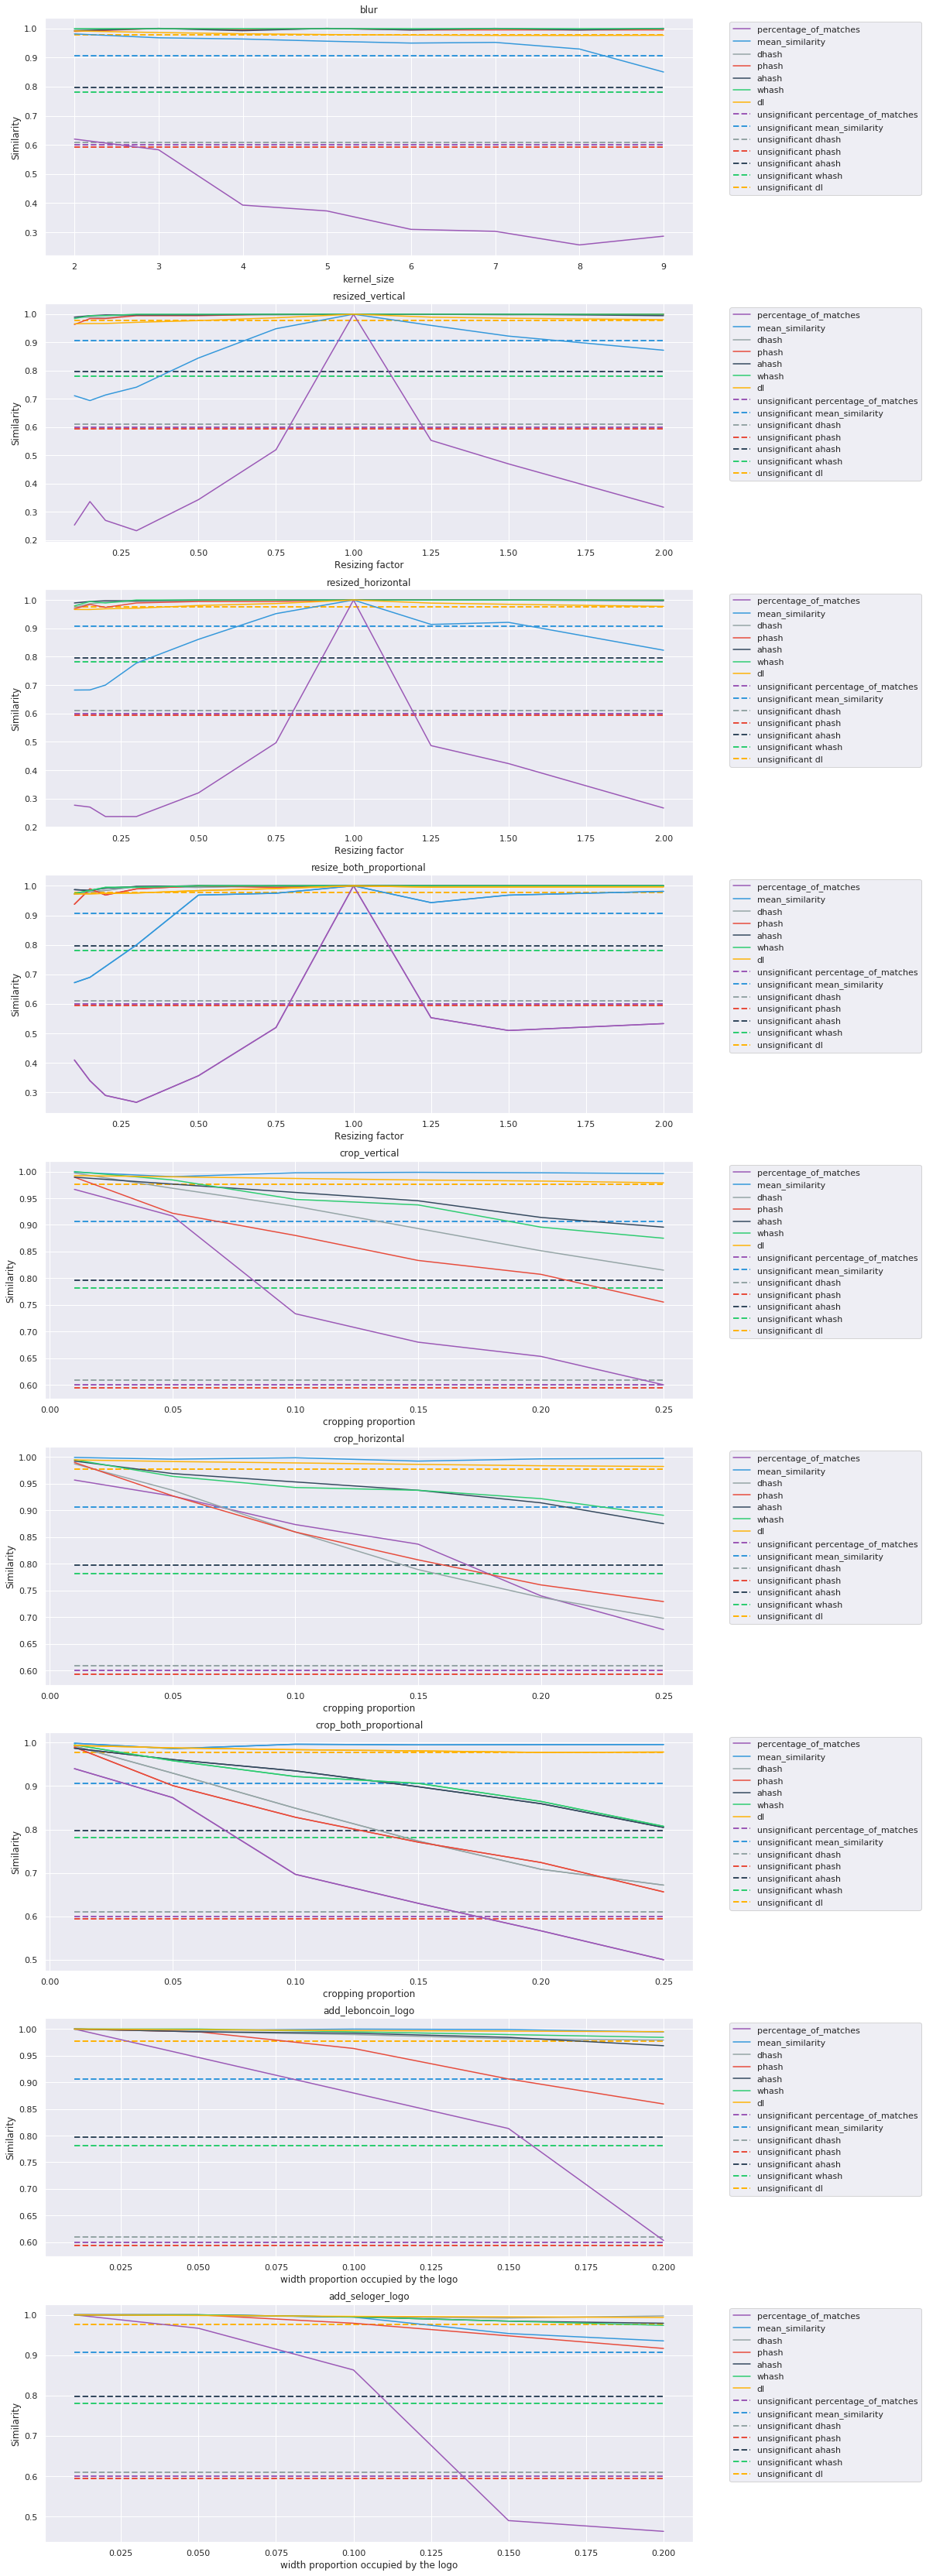

In [39]:
fig, axarr = plt.subplots(len(mean_similarities), 1, figsize=(15, 60))
for i, (transf_name, similarities) in enumerate(mean_similarities.items()):
    axes = []
    hlines = []
    index = transformation_dict[transf_name][1]
    max_index = max(index)
    min_index = min(index)
    for sim_name, values in similarities.items():
        ax = axarr[i].plot(index, values, color=colors[sim_name], label=sim_name)
        axes.append(ax[0])
        hl = axarr[i].hlines(
            max_similarities[sim_name], min_index, max_index, linestyles='dashed', color=colors[sim_name],
            label=f'unsignificant {sim_name}', lw=2
        )
        hlines.append(hl)
    axarr[i].legend(handles=axes+hlines, loc='upper left',bbox_to_anchor=(1.05, 1))
    axarr[i].set_title(transf_name)
    axarr[i].set_xlabel(xlabels[transf_name])
    axarr[i].set_ylabel('Similarity')


In [40]:
mean_similarities.keys()

dict_keys(['blur', 'resized_vertical', 'resized_horizontal', 'resize_both_proportional', 'crop_vertical', 'crop_horizontal', 'crop_both_proportional', 'add_leboncoin_logo', 'add_seloger_logo'])

In [41]:
mean_cropping = {}
for key in ['crop_both_proportional', 'crop_vertical', 'crop_horizontal']:
    mean_cropping[key] = mean_similarities[key]

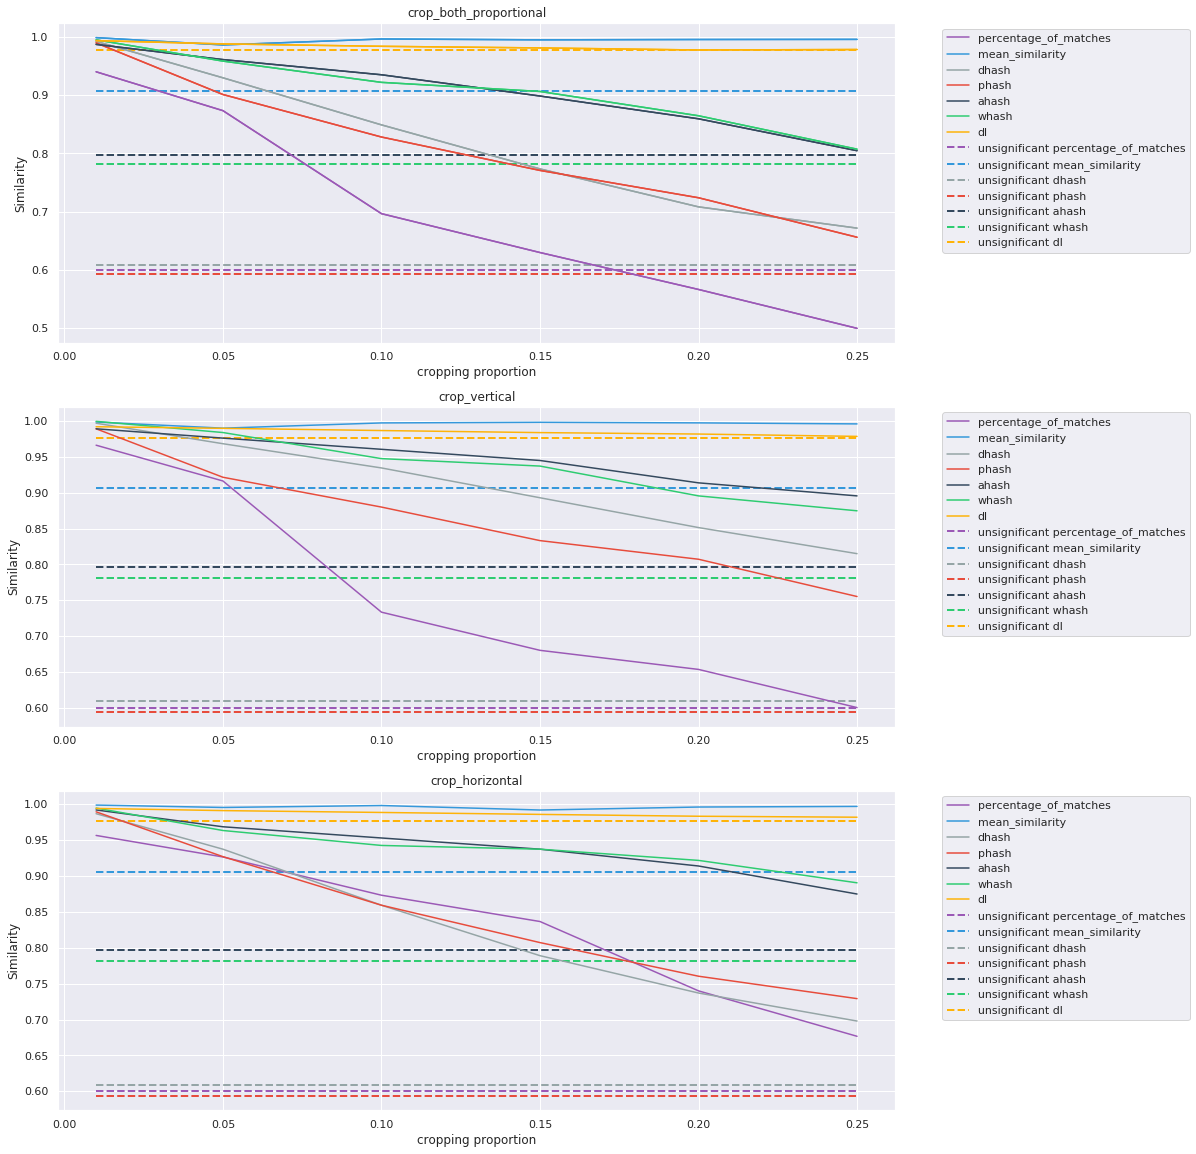

In [42]:
fig, axarr = plt.subplots(len(mean_cropping), 1, figsize=(15, 20))
for i, (transf_name, similarities) in enumerate(mean_cropping.items()):
    axes = []
    hlines = []
    index = transformation_dict[transf_name][1]
    max_index = max(index)
    min_index = min(index)
    for sim_name, values in similarities.items():
        ax = axarr[i].plot(index, values, color=colors[sim_name], label=sim_name)
        axes.append(ax[0])
        hl = axarr[i].hlines(
            max_similarities[sim_name], min_index, max_index, linestyles='dashed', color=colors[sim_name],
            label=f'unsignificant {sim_name}', lw=2
        )
        hlines.append(hl)
    axarr[i].legend(handles=axes+hlines, loc='upper left',bbox_to_anchor=(1.05, 1))
    axarr[i].set_title(transf_name)
    axarr[i].set_xlabel(xlabels[transf_name])
    axarr[i].set_ylabel('Similarity')
#plt.savefig('crop_similarities.jpg', bbox_inches='tight')

In [43]:
mean_resizing = {}
for key in ['resize_both_proportional', 'resized_vertical', 'resized_horizontal']:
    mean_resizing[key] = mean_similarities[key]

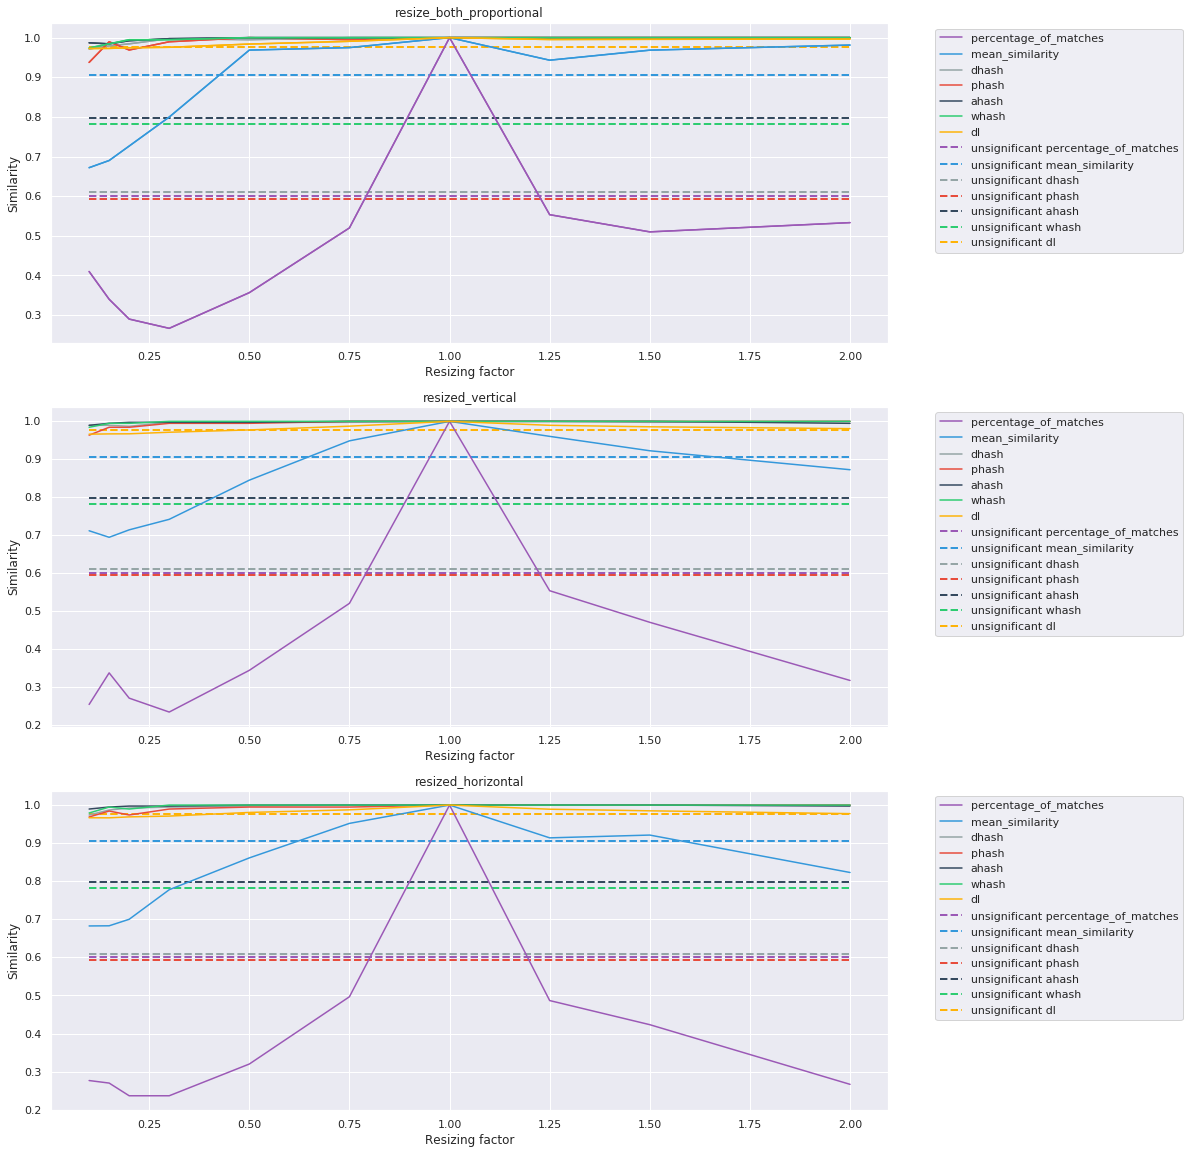

In [44]:
fig, axarr = plt.subplots(len(mean_resizing), 1, figsize=(15, 20))
for i, (transf_name, similarities) in enumerate(mean_resizing.items()):
    axes = []
    hlines = []
    index = transformation_dict[transf_name][1]
    max_index = max(index)
    min_index = min(index)
    for sim_name, values in similarities.items():
        ax = axarr[i].plot(index, values, color=colors[sim_name], label=sim_name)
        axes.append(ax[0])
        hl = axarr[i].hlines(
            max_similarities[sim_name], min_index, max_index, linestyles='dashed', color=colors[sim_name],
            label=f'unsignificant {sim_name}', lw=2
        )
        hlines.append(hl)
    axarr[i].legend(handles=axes+hlines, loc='upper left',bbox_to_anchor=(1.05, 1))
    axarr[i].set_title(transf_name)
    axarr[i].set_xlabel(xlabels[transf_name])
    axarr[i].set_ylabel('Similarity')
#plt.savefig('resize_similarities.jpg', bbox_inches='tight')

In [45]:
mean_others = {}
for key in ['add_leboncoin_logo', 'add_seloger_logo', 'blur']:
    mean_others[key] = mean_similarities[key]

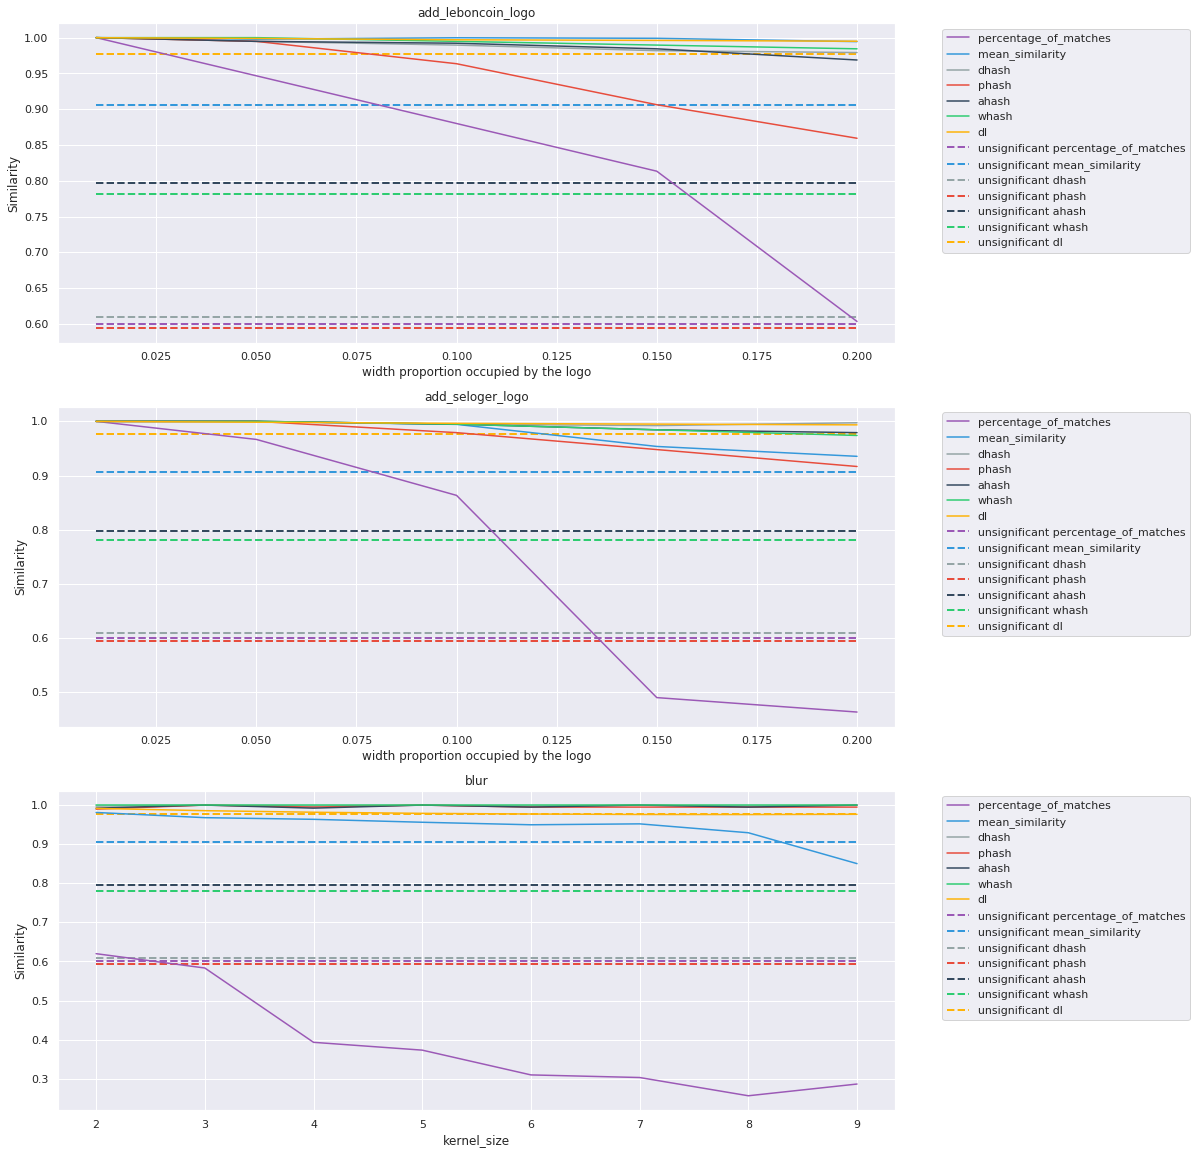

In [46]:
fig, axarr = plt.subplots(len(mean_others), 1, figsize=(15, 20))
for i, (transf_name, similarities) in enumerate(mean_others.items()):
    axes = []
    hlines = []
    index = transformation_dict[transf_name][1]
    max_index = max(index)
    min_index = min(index)
    for sim_name, values in similarities.items():
        ax = axarr[i].plot(index, values, color=colors[sim_name], label=sim_name)
        axes.append(ax[0])
        hl = axarr[i].hlines(
            max_similarities[sim_name], min_index, max_index, linestyles='dashed', color=colors[sim_name],
            label=f'unsignificant {sim_name}', lw=2
        )
        hlines.append(hl)
    axarr[i].legend(handles=axes+hlines, loc='upper left',bbox_to_anchor=(1.05, 1))
    axarr[i].set_title(transf_name)
    axarr[i].set_xlabel(xlabels[transf_name])
    axarr[i].set_ylabel('Similarity')
#plt.savefig('logo_blur_similarities.jpg', bbox_inches='tight')

###### Extraction duration

In [47]:
%%timeit

_ = extract_sift(images[:5])

177 ms ± 5.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [48]:
print(f'Extraction sift 50 features {170 / 5} ms +- {1.97/5} ms / img')

Extraction sift 50 features 34.0 ms +- 0.394 ms / img


In [49]:
%%timeit
for img in images[:5]:
    pil_img = Image.fromarray(np.uint8(img))
    _ = imagehash.dhash(pil_img)

6.94 ms ± 53.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
print(f'Extraction dhash features {6.87 / 5} ms +- {140 /5} µs / img')

Extraction dhash features 1.374 ms +- 28.0 µs / img


In [51]:
%%timeit
for img in images[:5]:
    pil_img = Image.fromarray(np.uint8(img))
    _ = imagehash.phash(pil_img)

8.61 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
print(f'Extraction phash features {8.76 / 5} ms +- {126 /5} µs / img')

Extraction phash features 1.752 ms +- 25.2 µs / img


In [53]:
%%timeit
for img in images[:5]:
    pil_img = Image.fromarray(np.uint8(img))
    _ = imagehash.average_hash(pil_img)

6.99 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
print(f'Extraction average hash features {6.79 / 5} ms +- {116 /5} µs / img')

Extraction average hash features 1.358 ms +- 23.2 µs / img


In [55]:
%%timeit
for img in images[:5]:
    pil_img = Image.fromarray(np.uint8(img))
    _ = imagehash.whash(pil_img)

39.3 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [56]:
print(f'Extraction  whash features {37.6/ 5} ms +- {562 /5} µs / img')

Extraction  whash features 7.5200000000000005 ms +- 112.4 µs / img


In [57]:
%%timeit 
for img in images[:5]:
    pil_img = Image.fromarray(np.uint8(img))
    _ = extract_dl_features(model, pil_img)

4.6 s ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
print(f'Extraction dl features {13.2 / 5} s +- {13.2/5} ms / img')

Extraction dl features 2.6399999999999997 s +- 2.6399999999999997 ms / img


In [59]:
print('Sizes of images used for computation time evalution:', [img.shape[:2] for img in images[:5]])

Sizes of images used for computation time evalution: [(460, 345), (460, 613), (460, 613), (460, 345), (460, 613)]


---------
| method|time (ms)|
|--|--|
|SIFT  | 34|
|DHASH | 1.38|
|PHASH | 1.75|
|AHASH | 1.36|
|WHASH | 7.5|
|DL    |2640|

###### Similarity duration

In [60]:
features = extract_sift(images[:5])

In [61]:
%%timeit
for features1 in features:
    for features2 in features:
        matches = extract_matches(features1[0], features1[1], features2[0], features2[1], lowe_ratio=0.99)
        percentage_of_matches(matches, nb_features)

473 ms ± 3.76 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
479 / 25

19.16

In [63]:
%%timeit
for features1 in features:
    for features2 in features:
        matches = extract_matches(features1[0], features1[1], features2[0], features2[1], lowe_ratio=0.99)
        mean_similarity(matches, features1[1], features2[1])

484 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
479/25

19.16

In [65]:
features = []
for image in images[:5]:
    pil_img = Image.fromarray(np.uint8(image))
    features.append(imagehash.dhash(pil_img))

In [66]:
%%timeit
hash_size=64
for features1 in features:
    for features2 in features:
        (hash_size - (features1 - features2))/hash_size

92.1 µs ± 2.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [67]:
features = []
for image in images[:5]:
    pil_img = Image.fromarray(np.uint8(image))
    features.append(extract_dl_features(model, pil_img))

In [68]:
features[1].dtype

dtype('float32')

In [69]:
%%timeit
for features1 in features:
    for features2 in features:
        similarity(features1, features2)

426 µs ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


----------
|method| time (ms)|
|------|------|
|Percentage of matches |  19.16 |
| mean similirity | 19.20|
| DHASH | 0.09 |
| PHASH | 0.09 |
| AHASH | 0.09 |
| WHASH | 0.09 |
| DL | 0.490 |

---------
| method|time (ms)|
|--|--|
|SIFT  | 34|
|DHASH | 1.38|
|PHASH | 1.75|
|AHASH | 1.36|
|WHASH | 7.5|
|DL    |2640|

###### Size

In [70]:
features = extract_sift(images[:5])

In [71]:
features[0][0][0]

<KeyPoint 0x133074c30>

In [72]:
import sys

In [73]:
x = extract_dl_features(model, pil_img)

--------------------
|methode| size of 1M features (GB) |
|-------|----------|
|Local  | 26 GB |
|Global | 8MB   |
|DL     | 8GB   |

In [74]:
50 * (4 * 2 + 128 * 4)

26000

In [75]:
4 * 2048 

8192